# AQI API Call

The code in this module is to make an API call to US EPA to retrieve AQI for Wichita, Kansas.
The code is adapted from the code example developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024.

In [2]:
import json, time
#
#    The 'requests' module is a distribution module for making web requests. If you do not have it already, you'll need to install it
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}



In [4]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")

    if '@' not in request_template['email']: 
        raise Exception(f"Must supply an email address to call 'request_signup()'. The string '{request_template['email']}' does not look like an email address.")

    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


You will need to signup first to be able to make API calls. Please refer to [epa_air_quality_history_example.ipynb](../resources/example_notebooks/epa_air_quality_history_example.ipynb) for more information.

In [5]:
# print("Requesting SIGNUP ...")
# USERNAME = "email@uw.edu"
# response = request_signup(USERNAME)
# print(json.dumps(response,indent=4))

I am using the module developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program to store my keys.
You can find out more from [here](../modules/apikeys.zip).

In [6]:
from apikeys.KeyManager import KeyManager
keyman = KeyManager()
USERNAME = "flim89@uw.edu"
key_info = keyman.findRecord(USERNAME,API_REQUEST_URL)
APIKEY = key_info[0]['key']


In [7]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [8]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [9]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"


In [10]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


In [11]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Using the fips code I found online, I was unable to find monitoring stations. Therefore, I used the bounding box example to find a station, and its fip code.

In [12]:
CITY_LOCATIONS =  {
    'wichita' :       {'city'   : 'Wichita',
                       'county' : 'Sedgwick',
                       'state'  : 'Kansas',
                       'fips'   : '20203', 
                       'latlon' : [37.6889, -97.3360] }
}

In [14]:
#
#    This implements the monitors request. This requests monitoring stations. This can be done by state, county, or bounding box. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_monitors(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_MONITORS_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_monitors()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_monitors()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_monitors()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_monitors()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_monitors()'")
    # Note we're not validating FIPS fields because not all of the monitors actions require the FIPS numbers
    
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
    
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [15]:
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES     # remember we have both gaseous and particulates
# 
#   We got the monitoring stations for Bend OR above (Deschutes county) - let's work with that one again
request_data['state'] = CITY_LOCATIONS['wichita']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['wichita']['fips'][2:]
#
# the first example uses the default - request monitors by county, we'll just use a recent date for now
response = request_monitors(request_template=request_data, begin_date="20210701", end_date="20210731")
#
# the response should be similar to the 'list' request above - but in this case we should only get monitors that
# monitor the AQI_PARAMS_PARTICULATES set of params.
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


{
    "Header": [
        {
            "status": "No data matched your selection",
            "request_time": "2024-10-30T20:54:14-04:00",
            "url": "https://aqs.epa.gov/data/api/monitors/byCounty?email=flim89@uw.edu&key=%20aquahawk32&param=81102,88101,88502&bdate=20210701&edate=20210731&state=20&county=203",
            "rows": 0
        }
    ],
    "Data": []
}


The code below attempts to find monitoring stations using bounding box.

In [16]:
#
#   These are rough estimates for creating bounding boxes based on a city location
#   You can find these rough estimates on the USGS website:
#   https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps
#
LAT_25MILES = 25.0 * (1.0/69.0)    # This is about 25 miles of latitude in decimal degrees
LON_25MILES = 25.0 * (1.0/54.6)    # This is about 25 miles of longitude in decimal degrees
#
#   Compute rough estimates for a bounding box around a given place
#   The bounding box is scaled in 50 mile increments. That is, the bounding box will have sides that
#   are rough multiples of 50 miles, with the center of the box around the indicated place.
#   The scale parameter determines the scale (size) of the bounding box
#
def bounding_latlon(place=None,scale=1.0):
    minlat = place['latlon'][0] - float(scale) * LAT_25MILES
    maxlat = place['latlon'][0] + float(scale) * LAT_25MILES
    minlon = place['latlon'][1] - float(scale) * LON_25MILES
    maxlon = place['latlon'][1] + float(scale) * LON_25MILES
    return [minlat,maxlat,minlon,maxlon]



In [17]:

request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_PARTICULATES     # same particulate request as the one abover
# 
#   Not going to use these - comment them out
#request_data['state'] = CITY_LOCATIONS['seaside']['fips'][:2]
#request_data['county'] = CITY_LOCATIONS['seaside']['fips'][2:]
#
#   Now, we need bounding box parameters

#   50 mile box - roughly within 25 miles of the location
bbox = bounding_latlon(CITY_LOCATIONS['wichita'],scale=1.0)
#   100 mile box - roughly within 50 miles of the location
#bbox = bounding_latlon(CITY_LOCATIONS['wichita'],scale=2.0)
#   150 mile box - roughly within 75 miles of the location
#bbox = bounding_latlon(CITY_LOCATIONS['seaside'],scale=3.0)
#   200 mile box
#bbox = bounding_latlon(CITY_LOCATIONS['seaside'],scale=4.0)

# the bbox response comes back as a list - [minlat,maxlat,minlon,maxlon]

#   put our bounding box into the request_data
request_data['minlat'] = bbox[0]
request_data['maxlat'] = bbox[1]
request_data['minlon'] = bbox[2]
request_data['maxlon'] = bbox[3]

#
#   we need to change the action for the API from the default to the bounding box - same recent date for now
response = request_monitors(request_template=request_data, begin_date="19640101", end_date="20241015",
                            endpoint_action = API_ACTION_MONITORS_BOX)
#
#
#
if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "state_code": "20",
        "county_code": "173",
        "site_number": "0007",
        "parameter_code": "81102",
        "poc": 1,
        "parameter_name": "PM10 Total 0-10um STP",
        "open_date": "1988-01-01",
        "close_date": "2003-12-29",
        "concurred_exclusions": null,
        "dominant_source": null,
        "measurement_scale": "NEIGHBORHOOD",
        "measurement_scale_def": "500 M TO 4KM",
        "monitoring_objective": "POPULATION EXPOSURE",
        "last_method_code": "063",
        "last_method_description": "HI-VOL SA/GMW-1200 - GRAVIMETRIC",
        "last_method_begin_date": "1988-01-01",
        "naaqs_primary_monitor": null,
        "qa_primary_monitor": null,
        "monitor_type": null,
        "networks": null,
        "monitoring_agency_code": "0563",
        "monitoring_agency": "Kansas Department Of Health And Environment",
        "si_id": 5555,
        "latitude": 37.708902,
        "longitude": -97.375601,
        "datum": "

Here I update the fips code. 

In [18]:
CITY_LOCATIONS =  {
    'wichita' :       {'city'   : 'Wichita',
                       'county' : 'Sedgwick',
                       'state'  : 'Kansas',
                       'fips'   : '20173', 
                       'latlon' : [37.6889, -97.3360] }
}

In [19]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[:2]        

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [20]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['wichita']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['wichita']['fips'][2:]

def yearly_aqi_req(aqi_param, year,request_data):
    request_data['param'] = aqi_param
    aqi = request_daily_summary(request_template=request_data, begin_date=f"{year}0501", end_date=f"{year}1031")
    print(f"Response for the gaseous pollutants for {year}...")

    if aqi["Header"][0]['status'] == "Success":
        return aqi['Data']
    elif aqi["Header"][0]['status'].startswith("No data "):
        print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
    else:
        print(json.dumps(aqi,indent=4))
        

We make the call for the two parameters (gaseous, and particulates) for the years between 1961-2024 (inclusive).

In [21]:
gas_aqi_list = []

for year in range(1961, 2025):
    gas_aqi_year = yearly_aqi_req(AQI_PARAMS_GASEOUS,year, request_data)
    if gas_aqi_year is None:
        continue
    
    gas_aqi_list += gas_aqi_year
    

Response for the gaseous pollutants for 1961...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1962...
Response for the gaseous pollutants for 1963...
Response for the gaseous pollutants for 1964...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1965...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1966...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1967...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1968...
Response for the gaseous pollutants for 1969...
Response for 

In [22]:
part_aqi_list = []

for year in range(1961, 2025):
    part_aqi_year = yearly_aqi_req(AQI_PARAMS_PARTICULATES, year, request_data)
    if part_aqi_year is None:
        continue
    
    part_aqi_list += part_aqi_year
    

Response for the gaseous pollutants for 1961...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1962...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1963...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1964...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1965...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1966...
Looks like the response generated no data. You might take a closer look at your request and the response data.
Response for the gaseous pollutants for 1967..

After retreiving the AQIs, we convert the lists into dataframes, and combine them into combined_aqi.

In [23]:
gas_aqi_df = pd.DataFrame(gas_aqi_list)
part_aqi_df = pd.DataFrame(part_aqi_list)

In [24]:
combined_aqi = pd.concat([gas_aqi_df, part_aqi_df], ignore_index=True)

I decided that the columns of interested were "parameter", "units_of_measure", "aqi", and "date_local". I also dropped the rows where the "aqi" column did not have any value.

In [25]:
columns_to_keep = [ "parameter","units_of_measure","aqi","date_local"]
df_filtered = combined_aqi[columns_to_keep]
df_filtered["aqi"].isna().sum()
aqi_cleaned_df = df_filtered.dropna()

I converted the datatype for the "date_local" column to datetime.

In [26]:
aqi_cleaned_df["date_local"] = pd.to_datetime(aqi_cleaned_df["date_local"])
aqi_cleaned_df["year"] = aqi_cleaned_df["date_local"].dt.year

C:\Users\fioyu\AppData\Local\Temp\ipykernel_37836\1238556661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_cleaned_df["date_local"] = pd.to_datetime(aqi_cleaned_df["date_local"])
C:\Users\fioyu\AppData\Local\Temp\ipykernel_37836\1238556661.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi_cleaned_df["year"] = aqi_cleaned_df["date_local"].dt.year


To plot, I calculated the average aqi grouping records by year and saved the result to an intermediate file [avg_aqi_per_year.csv](../intermediate_data/avg_aqi_per_year.csv))

In [27]:
avg_aqi_per_year = aqi_cleaned_df.groupby('year').agg(avg_aqi=('aqi', 'mean')).reset_index()

In [28]:
avg_aqi_per_year.to_csv('../intermediate_data/avg_aqi_per_year.csv', index=False)

The graph below is a time series graph showing the average AQI per year.

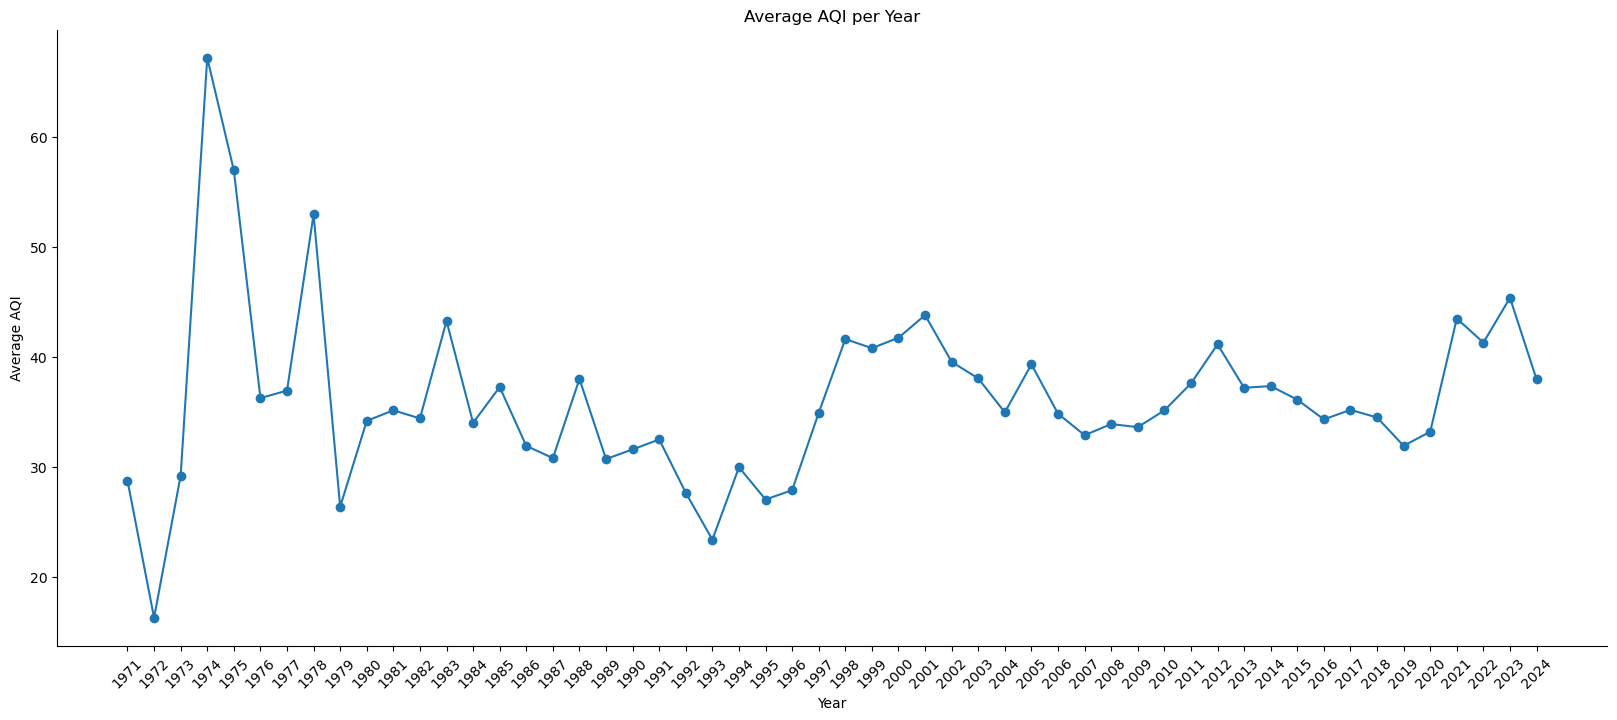

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(avg_aqi_per_year['year'], avg_aqi_per_year['avg_aqi'], marker='o', linestyle='-')
plt.title('Average AQI per Year')
plt.xlabel('Year')
plt.ylabel('Average AQI')

plt.grid(False) 
plt.gca().set_facecolor('white')  
plt.xticks(avg_aqi_per_year['year'], rotation=45)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()